In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad
from time import perf_counter as time

from tqdm import tqdm
from scipy import linalg, stats

import scipy as sp
from scipy.special import jacobi, legendre, roots_jacobi, eval_jacobi, factorial, gamma

# from tb_utils import JacobiGL, constructV, constructVx, constructD, z2x, z2x_dz, x2z, x2z_dx, evaluate_jacobi_grid, constructMinv, jacobi_p_normalisation_const
from tb_utils import *
import itertools
from scipy.sparse import diags, kron, eye, spdiags

import warnings
warnings.filterwarnings('ignore')

## Toy problem 1D

In [2]:
# eps = 0.001
eps = 0.1
x0, xN = 0, 1
g0, gN = 0, 0
# a_pde, b_pde, c_pde = -eps, -1, 0

def f(x): return np.ones(x.shape[0])

def u_exact_solution(x, eps=eps): return (np.exp(-x/eps) + (x - 1) - np.exp(-1/eps)*x)/(np.exp(-1/eps) - 1)

### Nodal Continous Galerkin - one domain

In [3]:
alpha, beta = 0, 0 # Legendere polynomials
N = 10
J = (xN - x0) / 2

z = JacobiGL(alpha=alpha, beta=beta, N=N) # z are the points in [-1,1]
D_z = constructD(z=z, alpha=alpha, beta=beta, a=-1, b=1)

M_inv = constructMinv(z=z, alpha=alpha, beta=beta, a=-1, b=1)
M = np.linalg.inv(M_inv)

L_N = (eps/J**2) * (D_z.T @ M @ D_z) - (1/J) * (M @ D_z)
L_N[0, :] = 0; L_N[0, 0] = 1
L_N[N, :] = 0; L_N[N, N] = 1
print(f"{np.linalg.cond(L_N)}")

w = 2 / (N * (N+1)) / np.power(eval_jacobi(N, alpha, beta, z), 2)
fx = w.copy()
fx[0] = g0; fx[N] = gN

u_z = linalg.solve(L_N, fx) # in nodal space

x = z2x(z=z, a=x0, b=xN)
u_x = u_z

63.117842835674146


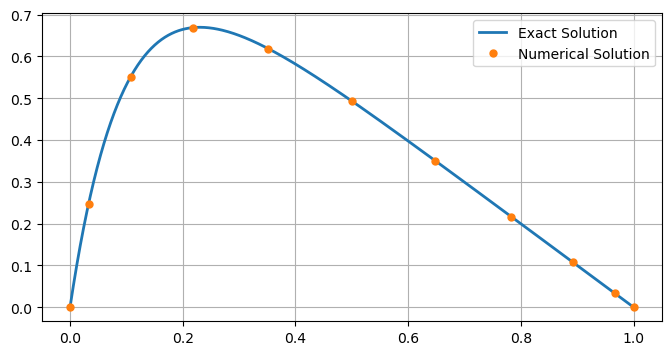

In [4]:
x_plot = np.linspace(x0, xN, 500)
u_exact_plot = u_exact_solution(x_plot, eps)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(x_plot, u_exact_plot, label="Exact Solution", linewidth=2)
ax.plot(x, u_x, 'o', label="Numerical Solution", markersize=5)
# ax[0].plot(x_eval, u_eval, linestyle='--', label="Interpolated Solution", linewidth=2)
ax.grid();
ax.legend();

### SEM - 2 domains

In [13]:
x_split = 0.1
alpha, beta = 0, 0 # Legendere polynomials
N = 10
J_1 = (x_split - x0) / 2
J_2 = (xN - x_split) / 2
print(f"{J_1 = }; {J_2 = }")

z = JacobiGL(alpha=alpha, beta=beta, N=N) # z are the points in [-1,1]
D_z = constructD(z=z, alpha=alpha, beta=beta, a=-1, b=1)
M_z_inv = constructMinv(z=z, alpha=alpha, beta=beta, a=-1, b=1)
M_z = np.linalg.inv(M_z_inv)

L_N_1 = (eps/J_1) * (D_z.T @ M_z @ D_z) - (M_z @ D_z)
L_N_1[0, :] = 0; L_N_1[0, 0] = 1
# L_N_1[N, :] = 0; L_N_1[N, N] = 1

L_N_2 = (eps/J_2) * (D_z.T @ M_z @ D_z) - (M_z @ D_z)
# L_N_2[0, :] = 0; L_N_2[0, 0] = 1
L_N_2[N, :] = 0; L_N_2[N, N] = 1

print(f"{np.linalg.cond(L_N_1) = }; {np.linalg.cond(L_N_2) = }")
# L_N = sp.linalg.block_diag(L_N_1, L_N_2)

w = 2 / (N * (N+1)) / np.power(eval_jacobi(N, alpha, beta, z), 2)
f_1 = J_1 * w.copy(); f_2 = J_2 * w.copy()
f_1[0] = g0;
f_2[N] = gN

L_N = np.zeros((2*(N+1)-1, 2*(N+1)-1))
f = np.zeros(2*(N+1)-1)

L_N[0:N+1, 0:N+1] += L_N_1
L_N[N:, N:] += L_N_2

f[0:N+1] += f_1
f[N:] += f_2

u_z = np.linalg.solve(L_N, f) # in nodal space

x_elem1 = z2x(z, x0, x_split)
x_elem2 = z2x(z, x_split, xN)
x_global = np.concatenate([x_elem1[:-1], x_elem2])

# x = z2x(z=z, a=x0, b=xN)
# u_x = u_z

J_1 = 0.05; J_2 = 0.45
np.linalg.cond(L_N_1) = np.float64(835.4060915836205); np.linalg.cond(L_N_2) = np.float64(75.17720809028569)


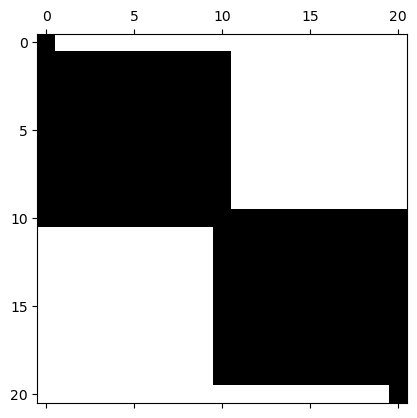

In [14]:
plt.spy(L_N)

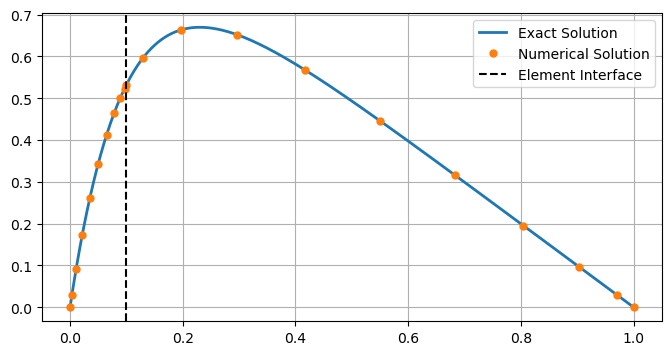

In [15]:
x_plot = np.linspace(x0, xN, 500)
u_exact_plot = u_exact_solution(x_plot, eps)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(x_plot, u_exact_plot, label="Exact Solution", linewidth=2)
ax.plot(x_global, u_z, 'o', label="Numerical Solution", markersize=5)
ax.axvline(x_split, color='k', linestyle='--', label='Element Interface')
ax.grid();
ax.legend();

### SEM - Multiple domains

## Understanding traingles

## Grid generation functions
based on section 6.1 in the yellow book

In [ ]:
def Psi(r, s, v1, v2, v3):
    x = -0.5 * (r + s) * v1[0] + 0.5 * (1 + r) * v2[0] + 0.5 * (1 + s) * v3[0]
    y = -0.5 * (r + s) * v1[1] + 0.5 * (1 + r) * v2[1] + 0.5 * (1 + s) * v3[1]
    return x, y

def coordinate_transformation_values(v1, v2, v3):
    xr, yr = (v2 - v1)/2
    xs, ys = (v3 - v1)/2
    J_det = xr * ys - xs * yr
    rx = ys / J_det
    ry = -xs / J_det
    sx = -yr / J_det
    sy = xr / J_det
    matrix = np.array([[rx, ry], [sx, sy]])
    return matrix, J_det

In [75]:
def barycentric_lattice(N):
    """
    Return array of shape (M,3) with barycentric coordinates (λ1, λ2, λ3)
    for integer (i,j) ≥ 0, i+j ≤ N:
        λ1 = i / N
        λ3 = j / N
        λ2 = 1 - λ1 - λ3
    where M = (N+1)(N+2)/2 is the number of points in the lattice.
    """
    i = np.arange(N+1)
    j = np.arange(N+1)
    I, J = np.meshgrid(i, j, indexing='ij')
    mask = (I + J) <= N
    lam1 = (I[mask] / N).astype(float)
    lam3 = (J[mask] / N).astype(float)
    lam2 = 1.0 - lam1 - lam3
    return np.vstack([lam1, lam2, lam3]).T

N = 10
lattice = barycentric_lattice(N)
# print(lattice)

v1_canonical, v2_canonical, v3_canonical = np.array([-1, -1]), np.array([1, -1]), np.array([-1, 1])

def lambda2xy(lambdas, v1, v2, v3):
    x = lambdas[:, 0] * v1[0] + lambdas[:, 1] * v2[0] + lambdas[:, 2] * v3[0]
    y = lambdas[:, 0] * v1[1] + lambdas[:, 1] * v2[1] + lambdas[:, 2] * v3[1]
    return x, y

r, s = lambda2xy(lattice, v1_canonical, v2_canonical, v3_canonical)

v1, v2, v3 = np.array([-1, 1]), np.array([2, 8]), np.array([5, 7])

x, y = Psi(r, s, v1, v2, v3)

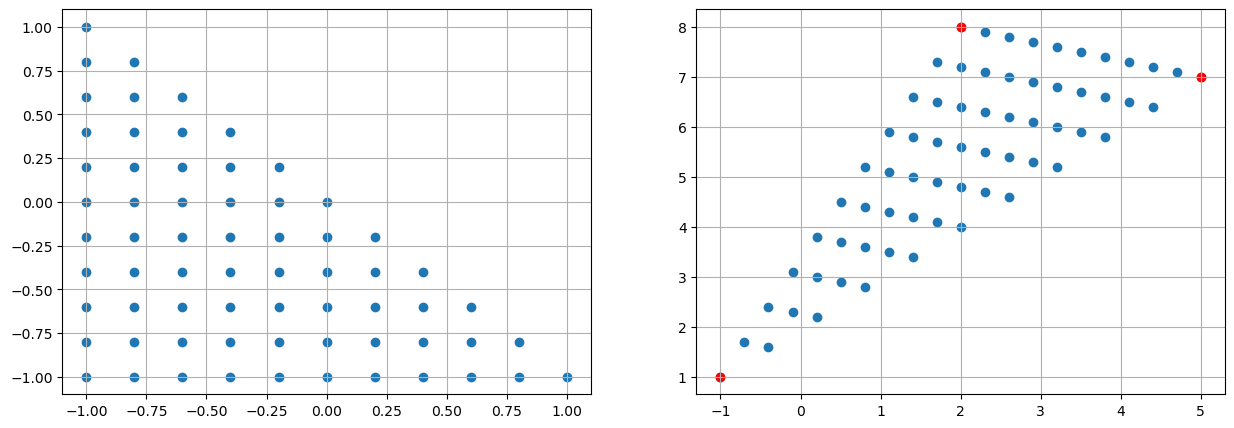

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(r, s)
ax[0].grid()
ax[1].scatter(x, y)
ax[1].scatter(v1[0], v1[1], color='r')
ax[1].scatter(v2[0], v2[1], color='r')
ax[1].scatter(v3[0], v3[1], color='r')
ax[1].grid()

In [172]:
v1_equilateral = np.array([0, 2/np.sqrt(3)])
v2_equilateral = np.array([-1, -1/np.sqrt(3)])
v3_equilateral = np.array([1, -1/np.sqrt(3)])

x, y = lambda2xy(lattice, v1_equilateral, v2_equilateral, v3_equilateral)

def equilateral2rs(x, y):
    L1 = (np.sqrt(3)*y + 1) / 3
    L2 = (-3*x - np.sqrt(3)*y + 2) / 6
    L3 = (3*x - np.sqrt(3)*y + 2) / 6
    r = -L2 + L3 - L1
    s = -L2 - L3 + L1
    return r, s

r, s = equilateral2rs(x, y)

print(np.sqrt(np.sum((v1_equilateral - v2_equilateral)**2)))
print(np.sqrt(np.sum((v2_equilateral - v3_equilateral)**2)))
print(np.sqrt(np.sum((v1_equilateral - v3_equilateral)**2)))

2.0000000000000004
2.0
2.0000000000000004


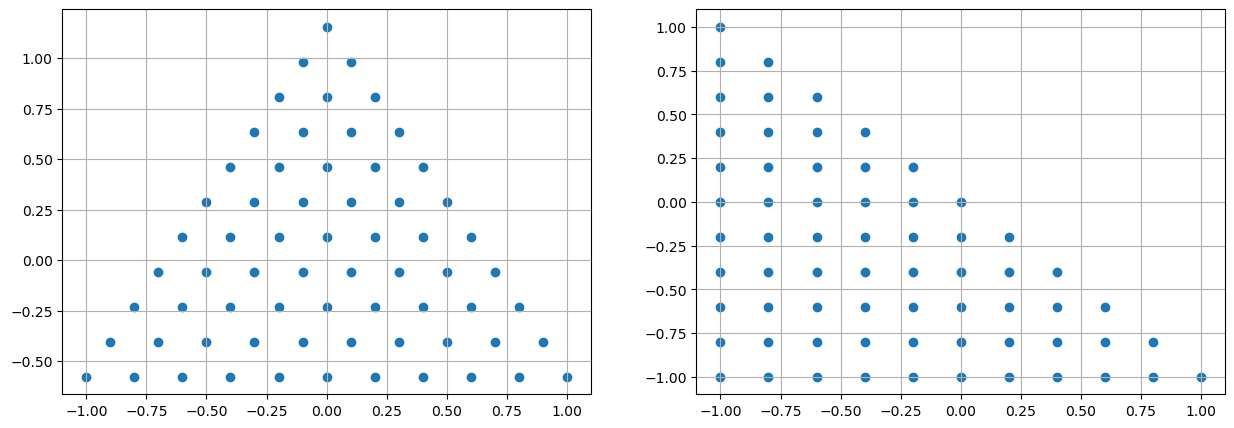

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(x, y)
ax[0].grid()
ax[1].scatter(r, s)
ax[1].grid()

In [ ]:
# Chat fully
def warpfactor(N, rout, alpha=0, beta=0):
    """
    Warp factor (Warp–Blend) for order N evaluated at rout (array in [-1,1]).
    """
    rout = np.asarray(rout, dtype=float)          # size Nr

    # 1) LGL (Jacobi–Gauss–Lobatto) nodes
    r_GL = JacobiGL(alpha=alpha, beta=beta, N=N)  # size N+1

    # 2) Equidistant nodes
    req = np.linspace(-1.0, 1.0, N+1)

    # 3) Vandermonde at equidistant nodes: Veq[j,i] = P_i(req[j])
    Veq = np.column_stack([eval_jacobi(i, alpha, beta, req) for i in range(N+1)])  # (N+1)x(N+1)

    # 4) Evaluate basis at rout (Pmat[j,i] = P_i(rout[j]))
    Pmat = np.column_stack([eval_jacobi(i, alpha, beta, rout) for i in range(N+1)])  # (Nr)x(N+1)

    # 5) Lagrange basis values at rout on req nodes:
    # Veq^T Lmat^T = Pmat^T  => Lmat^T = (Veq^T)^{-1} Pmat^T
    Lmat_T = np.linalg.solve(Veq.T, Pmat.T)       # (N+1)xNr
    # Each column j: ℓ_i(rout_j)

    # 6) Displacement d_i
    disp = r_GL - req                             # (N+1,)

    # 7) Interpolate displacement
    warp = (Lmat_T.T @ disp)                      # (Nr,)

    # 8) Blend (vanish at endpoints)
    zerof = (np.abs(rout) < 1.0 - 1.0e-10)
    sf = 1.0 - (zerof * rout)**2                  # (Nr,)
    warp = warp / sf + warp * (~zerof) * (-1.0)   # when |r|≈1 force to 0

    return warp

# Example
N = 50
r_plot = np.linspace(-1, 1, 70)
w = warpfactor(N, r_plot)

# plt.scatter(r_plot, w)
# plt.plot(r_plot, r_plot, linestyle='--', color='k')

In [165]:
# Chat fully
def nodes2d(N):
    """
    Compute (x,y) warp–blend nodes in an equilateral triangle for polynomial order N.
    Returns arrays x,y of length (N+1)(N+2)/2.
    """
    if N == 0:
        # Triangle vertices (equilateral of side 2 centered)
        return np.array([0.0]), np.array([0.0])
    # Optimized alpha (same list as in original code; MATLAB 1-based → Python 0-based)
    alpopt = [0.0000, 0.0000, 1.4152, 0.1001, 0.2751, 0.9800, 1.0999,
              1.2832, 1.3648, 1.4773, 1.4959, 1.5743, 1.5770, 1.6223, 1.6258]
    alpha = alpopt[N] if N < 16 else 5/3

    Np = (N+1)*(N+2)//2
    L1 = np.zeros(Np); L2 = np.zeros(Np); L3 = np.zeros(Np)
    sk = 0
    for n in range(1, N+2):
        for m in range(1, N+3 - n):
            L1[sk] = (n-1)/N
            L3[sk] = (m-1)/N
            sk += 1
    L2 = 1.0 - L1 - L3

    # Initial equidistributed coordinates in equilateral triangle
    x = -L2 + L3
    y = (-L2 - L3 + 2*L1)/np.sqrt(3.0)

    # Blending functions
    blend1 = 4.0 * L2 * L3
    blend2 = 4.0 * L1 * L3
    blend3 = 4.0 * L1 * L2

    # Edge warp amounts
    warpf1 = warpfactor(N, L3 - L2)
    warpf2 = warpfactor(N, L1 - L3)
    warpf3 = warpfactor(N, L2 - L1)

    # Combine (edge-wise scaling factors)
    warp1 = blend1 * warpf1 * (1.0 + (alpha * L1)**2)
    warp2 = blend2 * warpf2 * (1.0 + (alpha * L2)**2)
    warp3 = blend3 * warpf3 * (1.0 + (alpha * L3)**2)

    # Accumulate deformations (rotations 0, 120°, 240°)
    x = x + 1.0*warp1 + np.cos(2*np.pi/3)*warp2 + np.cos(4*np.pi/3)*warp3
    y = y + 0.0*warp1 + np.sin(2*np.pi/3)*warp2 + np.sin(4*np.pi/3)*warp3

    return x, y

In [174]:
N = 16
x_equilateral, y_equilateral = nodes2d(N)
print(f"{x_equilateral.shape = }; {y_equilateral.shape = }")
print(f"{(N+1)*(N+2)//2 = };")

r, s = equilateral2rs(x_equilateral, y_equilateral)

v1, v2, v3 = np.array([-1, 1]), np.array([2, 8]), np.array([5, 7])

x, y = Psi(r, s, v1, v2, v3)

x_equilateral.shape = (153,); y_equilateral.shape = (153,)
(N+1)*(N+2)//2 = 153;


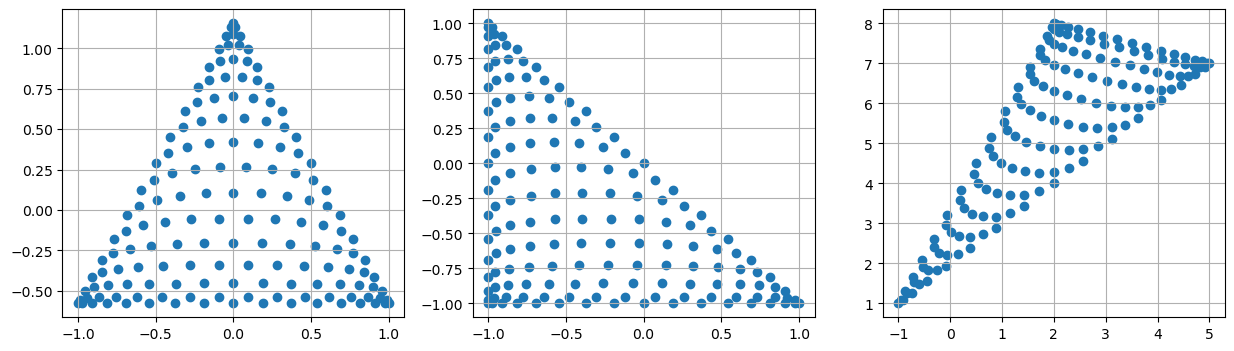

In [175]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(x_equilateral, y_equilateral)
ax[0].grid()
ax[1].scatter(r, s)
ax[1].grid()
ax[2].scatter(x, y)
ax[2].grid()

## Toy problem 2D

### square = 2 triangles

In [180]:
V_x = np.array([-1, 1, 1, -1])
V_y = np.array([-1, -1, 1, 1])
EtoV = np.array([[1, 2, 4],
                [2, 3, 4]]) - 1

In [212]:
# array of size (3, 2) contining (v1, v2, v3)
V1 = np.vstack([V_x[EtoV[0, :]], V_y[EtoV[0, :]]]).T
V2 = np.vstack([V_x[EtoV[1, :]], V_y[EtoV[1, :]]]).T
print(V1)

[[-1 -1]
 [ 1 -1]
 [-1  1]]


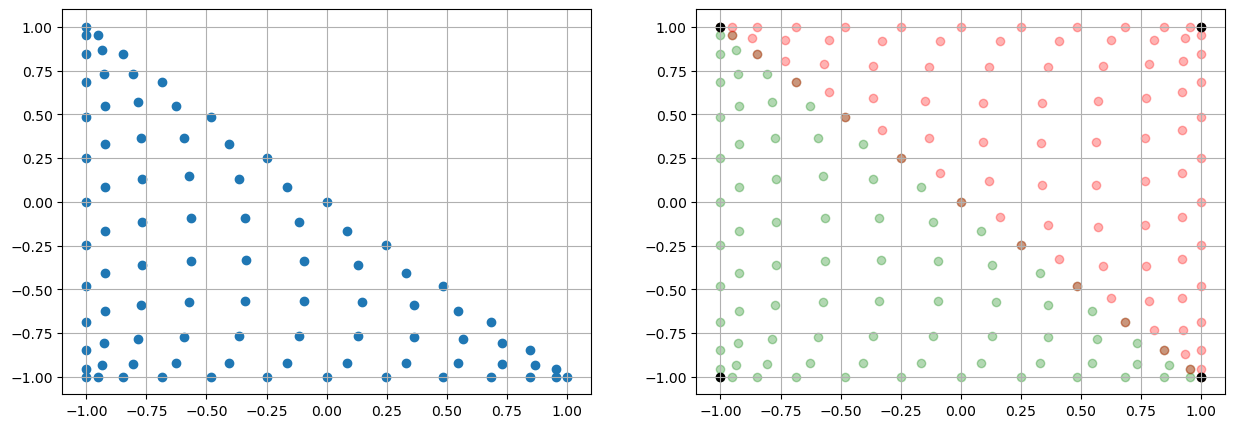

In [218]:
N = 12
x_equilateral, y_equilateral = nodes2d(N)
r, s = equilateral2rs(x_equilateral, y_equilateral)

x1, y1 = Psi(r, s, V1[0, :], V1[1, :], V1[2, :])
x2, y2 = Psi(r, s, V2[0, :], V2[1, :], V2[2, :])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(r, s)
ax[0].grid()
ax[1].scatter(x1, y1, color = "green", alpha = 0.3)
ax[1].scatter(x2, y2, color = "red", alpha = 0.3)
ax[1].scatter(V_x, V_y, color = "black")
ax[1].grid()

In [226]:
def rs2ab(r, s):
    a = 0.5 * (1 + r) * (1 - s) - 1
    b = s
    return a, b

def Simplex2DP(a, b, i, j):
    # orthonormal basis
    h1 = eval_jacobi(i, 0, 0, a)
    h2 = eval_jacobi(j, 2*i + 1, 0, b)
    P = np.sqrt(2.0) * h1 * h2 * (1 - b)**i
    return P

def vandermonde2d(N, r, s):
    """
    Build 2D Vandermonde matrix V where V[p,k] = φ_k(r_p,s_p)
    using simplex basis on reference triangle.
    r,s: arrays of node coordinates (same length).
    Returns V of shape (num_nodes, (N+1)(N+2)/2).
    """
    r = np.asarray(r)
    s = np.asarray(s)
    a, b = rs2ab(r, s)
    num_nodes = r.shape[0]
    num_modes = (N + 1)*(N + 2)//2
    V = np.zeros((num_nodes, num_modes))
    sk = 0
    for i in range(N + 1):
        for j in range(N - i + 1):
            V[:, sk] = Simplex2DP(a, b, i, j)
            sk += 1
    return V

In [ ]:
V = vandermonde2d(N, r, s) 
print(f"{np.linalg.cond(V) = }")

np.linalg.cond(V) = np.float64(1697924020346.6482)


np.linalg.cond(V) = np.float64(1697924020346.6482)


### Multiple domains